# Grid Manipulation in KANs

This is the Part 3 of the Tutorial series on KAN. In the previous two parts, we looked at the fundamental components of KANs, focusing on spline activations and performing backpropagation within networks composed of such activation functions.

In this notebook, we will uncover the benefits of KANs. Specifically,

- We will explore how the model's capacity can be expanded easily during training. This flexibility greatly enhances the reusability of models, allowing a previously trained model to be enlarged or pruned while continuing to learn, rather than requiring retraining from scratch.

- We will demonstrate how KANs effectively retain knowledge across diverse input distributions without suffering from catastrophic forgetting. This capability facilitates continual learning, ensuring the model adapts without losing previously acquired knowledge.


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

import matplotlib.pyplot as plt
from utils import eval_basis_functions, get_coeff, single_stacked_kan_training, single_stacked_mlp_training

## Section 1: Enhancing model capacity mid-training

To increase the capacity of a KAN without adding more neurons (or splines), you can augment the number of parameters by increasing the number of control points. This involves adjusting the existing grid to accommodate more control points.

**Procedure for Increasing Parameters:**
1. **Adapting Control Points**: The goal is to fit more control points into the existing grid. To achieve this, we utilize a spline that maps standard grid control points, typically ranging from $ [-1, 1] $, to those in the existing grid. We calculate temporary coefficients (`temp_coef`) for this purpose.
2. **Generating More Control Points**: With the mapping spline established, we can predict and generate as many control points as needed within the existing grid.

This approach becomes particularly useful when the existing grid's control points are non-uniformly spaced, as a spline provides a methodical way to interpolate and form new control points. However, other techniques might also be used to extend the grid with additional control points.

In [3]:
k=3
coarse_grid_size = 10
finer_grid_size = 20

preacts = torch.rand((100, 1))
postacts = torch.sin(preacts) + torch.randn(preacts.shape) * 0.1

# find the new control points
prev_grid = torch.linspace(-2.5, 2, steps=coarse_grid_size).unsqueeze(dim=0) # we need to increase the contorl points here

# learn the spline to predict the control points in the existing grid
x_pos = prev_grid.transpose(1,0)
temp_grid = torch.linspace(-1, 1, steps=coarse_grid_size).unsqueeze(dim=0)
temp_bases = eval_basis_functions(temp_grid.transpose(1, 0), temp_grid, k=1) # linear interpolate into a smaller grid. Shape [10,1,10]
temp_coef = get_coeff(temp_bases, x_pos) # shape:10

# let's predict more control points using the above spline
percentiles = torch.linspace(-1, 1, steps=finer_grid_size).unsqueeze(dim=1)
percentiles_basis = eval_basis_functions(percentiles, temp_grid, k=1) #shape: [20,1,10] that has 20 samples on 10 B-splines
new_grid = torch.einsum('ijk, bij-> bk', temp_coef, percentiles_basis).transpose(1, 0) # 20 controls points


# find the coefficients (predicitng the same postacts from preacts but using the new control points)
new_bases = eval_basis_functions(preacts, new_grid, k) #Shape [20,1,10]
new_coef = get_coeff(new_bases, postacts)# shape:20


Let's put it in a function

In [4]:
def update_grid(prev_grid, new_grid_size, k, preacts, postacts):
    """
    Updates grid.

    Args:
        prev_grid: number of splines x number of control points
        new_grid_size: new number of control points
        k: spline-order
        preacts: inputs to the grid
        postacts: current outputs to the grid. 

    Returns:
        new_coef: New coefficients to maintain the behavior of the current spline-activation
        new_grid: new grid with new control points
    """
    coarse_grid_size = prev_grid.shape[-1]
    finer_grid_size = new_grid_size
    
    # learn the spline to predict the control points in the existing grid
    x_pos = prev_grid.transpose(1,0)
    temp_grid = torch.linspace(-1, 1, steps=coarse_grid_size).unsqueeze(dim=0)
    temp_bases = eval_basis_functions(temp_grid.transpose(1, 0), temp_grid, k=1) # linear interpolate into a smaller grid
    temp_coef = get_coeff(temp_bases, x_pos)
    
    # let's predict more control points using the above spline
    percentiles = torch.linspace(-1, 1, steps=finer_grid_size).unsqueeze(dim=1)
    percentiles_basis = eval_basis_functions(percentiles, temp_grid, k=1)
    new_grid = torch.einsum('ijk, bij-> bk', temp_coef, percentiles_basis).transpose(1, 0)
    
    # find the coefficients (predicitng the same postacts from preacts but using the new control points)
    new_bases = eval_basis_functions(preacts, new_grid, k)
    new_coef = get_coeff(new_bases, postacts)

    return new_coef, new_grid


# Using KAN to predict function $f(x) = e^{sin(\pi x) + x^2} + \frac{1}{1+x^2}$

- Step 1: generate train, test and ground true data points 
- Step 2: initialize number of control points (3 in this case, order k=2) and generate B-splines. 
- Step 3: train KAN to fit target values and get coeffients
- step 3: enter loop to increase number of control points (resolution of B-splines) to [5,8,10,12] 
- Step 4: use the old grid to generate basis function, get coefficient with new grids as samples, generate new basis function
- step 5: get coefficient with new basis function.
- step 6: go back to step 3


<>:3: SyntaxWarning: invalid escape sequence '\p'
<>:3: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_1813/967755210.py:3: SyntaxWarning: invalid escape sequence '\p'
  fn, fn_label = (lambda x: torch.exp(torch.sin(torch.pi* x) + x**2) + (1 / (1 + x**2)), '$f(x) = e^{sin(\pi x) + x^2} + \\frac{1}{1+x^2}$')


torch.Size([999, 1])
torch.Size([999, 1])
Stopping: No further improvements...
Increasing number of parameters to 5: Prev grid: torch.Size([1, 3]) New grid: torch.Size([1, 5]) Prev. Coef: torch.Size([1, 4, 1]) New Coef: torch.Size([1, 6, 1])
Stopping: No further improvements...
Increasing number of parameters to 8: Prev grid: torch.Size([1, 5]) New grid: torch.Size([1, 8]) Prev. Coef: torch.Size([1, 6, 1]) New Coef: torch.Size([1, 9, 1])
Stopping: Iteration limit reached...
Increasing number of parameters to 10: Prev grid: torch.Size([1, 8]) New grid: torch.Size([1, 10]) Prev. Coef: torch.Size([1, 9, 1]) New Coef: torch.Size([1, 11, 1])
Stopping: Iteration limit reached...
Increasing number of parameters to 12: Prev grid: torch.Size([1, 10]) New grid: torch.Size([1, 12]) Prev. Coef: torch.Size([1, 11, 1]) New Coef: torch.Size([1, 13, 1])
Stopping: Iteration limit reached...


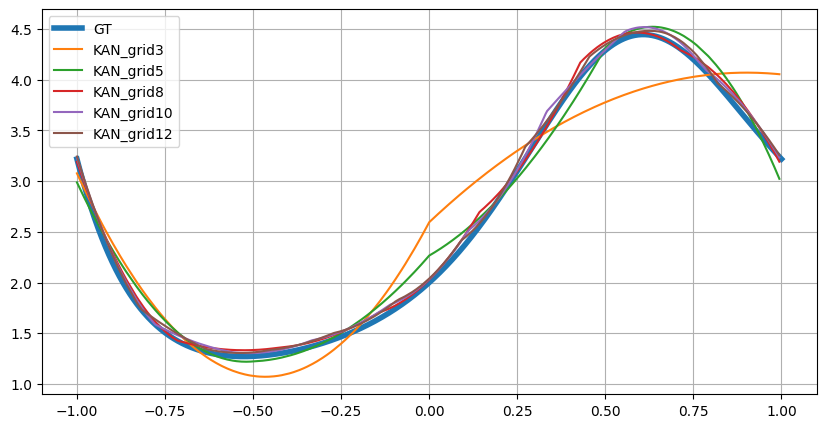

In [5]:
# fn, fn_label = lambda x: torch.sin(torch.pi * x),  '$sin(\pi x)$'
# fn, fn_label = (lambda x: torch.exp(torch.exp(-x)) + torch.sin(torch.pi * x) + torch.exp(torch.sin(x)), '$e^{e^{-x}} + sin(\pi \cdot x) + e^{sin(x)}$')
fn, fn_label = (lambda x: torch.exp(torch.sin(torch.pi* x) + x**2) + (1 / (1 + x**2)), '$f(x) = e^{sin(\pi x) + x^2} + \\frac{1}{1+x^2}$')

x_eval = torch.linspace(-1, 1, steps=999).unsqueeze(dim=1)
y_target = fn(x_eval) + 0.1 * torch.rand(x_eval.shape)

print(x_eval.shape)
print(y_target.shape)


# test and train split
n_training = int(x_eval.shape[0] * 0.8)
training_idxs = np.random.randint(x_eval.shape[0], size=n_training)
test_idxs = [i for i in range(x_eval.shape[0]) if i not in training_idxs]
x_training = x_eval[training_idxs]
x_test = x_eval[test_idxs]
y_training = y_target[training_idxs]
y_test = y_target[test_idxs]

lr = 0.1
k = 2
n_layers = 1
grid_sizes = [3]
grid_range = [-1, 1]

loss_batches = []

params_kan, y_pred_kan, losses_kan, all_xs = single_stacked_kan_training(x_training, y_training, x_test, y_test, lr=lr, 
                                                                         k=k, n_layers=n_layers, 
                                                                         grid_sizes=grid_sizes, verbose=False, 
                                                                         grid_range=[], use_scales=False)
loss_batches.append(losses_kan)

fig, axs=plt.subplots(nrows=1,ncols=1, figsize=(10,5),dpi=100)
axs.plot(x_eval, fn(x_eval), linewidth=4, label='GT')
axs.plot(x_test, y_pred_kan, label=f'KAN_grid3')
for new_grid_size in [5, 8, 10, 12]:    
    prev_grid = params_kan['grids'][0]
    prev_coef = params_kan['coeffs'][0]
    postacts = all_xs[-1][0]
    new_coef, new_grid = update_grid(prev_grid, new_grid_size, k, x_training, postacts)
    
    new_coef = new_coef.requires_grad_(True)
    params_kan['grids'] = [new_grid]
    params_kan['coeffs'] = [new_coef]

    print(f"Increasing number of parameters to {new_grid_size}: Prev grid: {prev_grid.shape} New grid: {new_grid.shape} Prev. Coef: {prev_coef.shape} New Coef: {new_coef.shape}")

    params_kan, y_pred_kan, losses_kan, all_xs = single_stacked_kan_training(x_training, y_training, x_test, y_test, model_params=params_kan, lr=lr, 
                                                                             k=k, n_layers=n_layers, 
                                                                             grid_sizes=grid_sizes, verbose=False, 
                                                                             grid_range=[], use_scales=False)


    loss_batches.append(losses_kan)
    axs.plot(x_test, y_pred_kan, label=f'KAN_grid{new_grid_size}')
axs.legend()
axs.grid()

Text(0.5, 1.0, 'Loss:\n$f(x) = e^{sin(\\pi x) + x^2} + \\frac{1}{1+x^2}$')

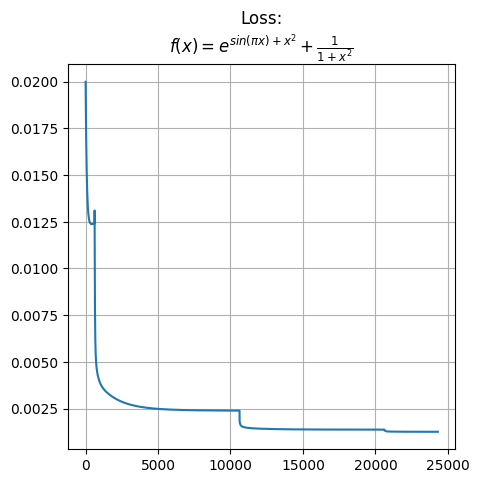

In [5]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5, 5), dpi=100)

axs.plot([x for losses in loss_batches for x in losses['val'] if x < 0.02])
axs.grid()
axs.set_title(f"Loss:\n{fn_label}")

**Obseravtions:** 

With every expansion in model capacity, we observe an increase in the generalization power of the [1, 1] KAN.

## Section 2: Continual Learning

In continual learning, the domain of inputs changes over time. In traditional deep learning models, using data from a new task as training data often leads to "catastrophic forgetting," where the network begins to forget previously learned tasks. KANs effectively overcome this issue. The reason lies in their use of B-splines as activation functions. B-splines exhibit a property of locality, meaning that adjustments to specific points can be made without affecting the global curve. This feature is crucial in KAN activation functions, allowing them to adapt to new input domains seamlessly while preserving their behavior in previous contexts.

Let's explore this capability in practice...

First, we will wrap our KAN prediction in a function to avoid code repetition. 

In [6]:
def model_predict(params_kan, x_eval, k):
    """
    Implements prediction functions using raw KANs. 
    """
    grids = params_kan['grids']
    coeffs = params_kan['coeffs']
    scale_bases = params_kan['scale_bases']
    scale_splines = params_kan['scale_splines']
    base_fns = params_kan['base_fns']
    
    for idx in range(len(grids)):
        grid, coeff = grids[idx], coeffs[idx]
        
        with torch.no_grad():
            x = torch.einsum('ijk, bij -> bk', coeff, eval_basis_functions(x_eval, grid, k))
            if len(base_fns) > 0:
                base_fn, scale_sp, scale_base =  base_fns[idx], scale_splines[idx], scale_bases[idx]
                x = scale_base * base_fn(x_eval) + scale_sp * x
                
        y_pred = x_eval = x
        
    
    return y_pred

### Case I: oscillator equation
We will create a dataset that learn armonic oscillator equation in sevearl phases. Each phases use new data set has varying input ranges. The challenge is to train a [1, 1] KAN on this dataset in a task-by-task manner, where observations from each task are presented sequentially rather than all at once.

$$
x(t) = e^{-\delta t}(2 A \cos(\phi + \omega t))~,~~~~~\mathrm{with}~~\omega=\sqrt{\omega_0^2 - \delta^2}~.
$$
we use $\delta=2$, $\omega_0=20$, and try to learn the solution over the domain $x\in [0,1]$.

In [7]:
def oscillator(d, w0, x):
    """Defines the analytical solution to the 1D underdamped harmonic oscillator problem. 
    Equations taken from: https://beltoforion.de/en/harmonic_oscillator/"""
    assert d < w0
    w = np.sqrt(w0**2-d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    cos = torch.cos(phi+w*x)
    #sin = torch.sin(phi+w*x)
    exp = torch.exp(-d*x)
    y  = exp*2*A*cos
    return y

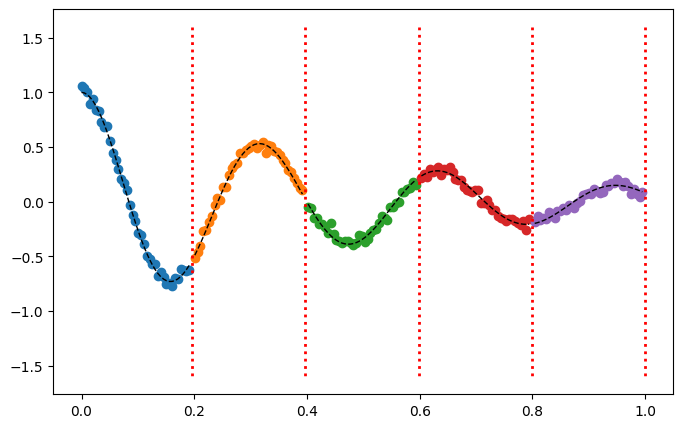

In [15]:
# Set random seed for reproducibility
torch.random.manual_seed(42)

fig, ax = plt.subplots(1, 1, figsize=(8, 5), dpi=100)

# Data generation parameters
n_samples_per_phase = 40
noise_level = 0.03
n_phases = 5

data_list, GT_list = [],[]
d, w0 = 2, 20

# get the analytical solution over the full domain
x = torch.linspace(0,1,n_phases*n_samples_per_phase).view(-1,1)
y = oscillator(d, w0, x).view(-1,1)

seg_num = int(x.shape[0]/n_phases)
for i in range(n_phases):
    start = i * seg_num 
    end = start + seg_num -1
    x_p = x[start:end]
    y_p = y[start:end]
    y_noisy=y_p + noise_level * torch.randn(y_p.shape)
    data_list.append((x_p,y_noisy))
    GT_list.append((x_p,y_p))
    ax.scatter(x_p, y_noisy)
    ax.vlines(x[end], 1.6, -1.6, color='red', linestyle=':', linewidth=2)
    ax.plot(x_p, y_p, color='black', linewidth=1, linestyle='--')
    

Let's prepare the dataset to train the KAN parameters as well as a similar size of MLP to see the differece. We will consider a scenario involving three tasks, each represented by a dataset with a distinct functional form defined over separate input domains.

In [9]:
class MLP(nn.Module):
    "Defines a connected network"
    
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)
        
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

Stopping: No further improvements...
Stopping: No further improvements...
Phase: 0	 KAN Loss:  0.0036
Phase: 0	 MLP Loss:  0.0828
Stopping: No further improvements...
Stopping: Iteration limit reached...
Phase: 1	 KAN Loss:  0.0009
Phase: 1	 MLP Loss:  0.1148
Stopping: No further improvements...
Stopping: No further improvements...
Phase: 2	 KAN Loss:  0.0016
Phase: 2	 MLP Loss:  0.0517
Stopping: No further improvements...
Stopping: No further improvements...
Phase: 3	 KAN Loss:  0.0035
Phase: 3	 MLP Loss:  0.0477
Stopping: No further improvements...
Stopping: No further improvements...
Phase: 4	 KAN Loss:  0.0014
Phase: 4	 MLP Loss:  0.0156
MLP Avg. loss:  0.01559
KAN Avg. loss:  0.00145


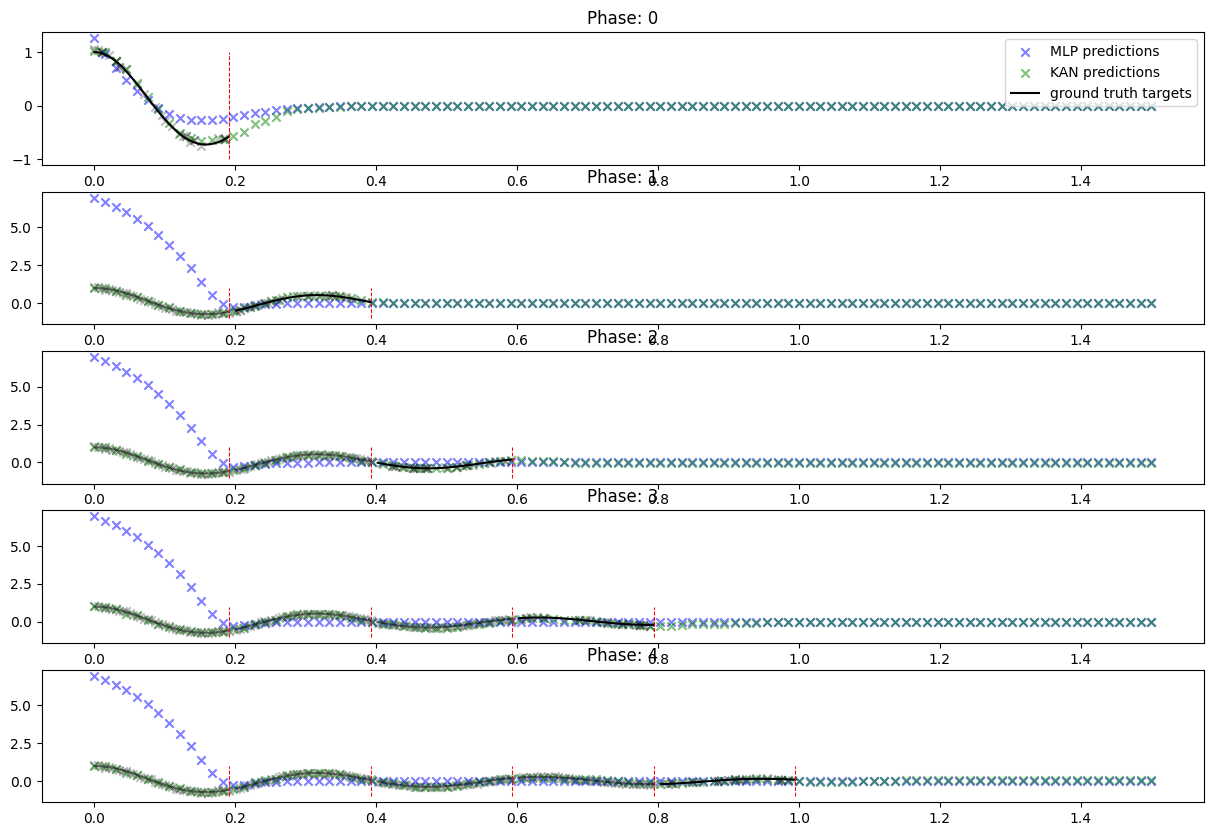

In [17]:
# %%
fig, axs = plt.subplots(nrows=n_phases, ncols=1, figsize=(15, 10), dpi=100)

# Setting for KAN
losses = []
grid_sizes = [32,32,32]
grid_range = [-1, 1]
lr = 0.1
k = 3
n_layers = 2

# Setting for MLP
layer_sizes = [32, 32,32] 
# train standard neural network to fit training data
torch.manual_seed(123)
model = MLP(1,1,32,3)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)

params_kan, params_mlp = None,None
x_temps, y_temps, ends, y_noisys = [], [], [], []
for i in range(n_phases):
    # reterive local data
    x_eval,y_target=data_list[i]

    # test and train split
    n_training = int(x_eval.shape[0] * 0.8)
    training_idxs = np.random.randint(x_eval.shape[0], size=n_training)
    test_idxs = [i for i in range(x_eval.shape[0]) if i not in training_idxs]
    x_training = x_eval[training_idxs]
    x_test = x_eval[test_idxs]
    y_training = y_target[training_idxs]
    y_test = y_target[test_idxs]

    # train using the same model (model_params=params_kan)
    params_kan, y_pred_kan, losses_kan, all_xs = single_stacked_kan_training(x_training, y_training, x_test, y_test, lr=lr, model_params=params_kan, 
                                                                             k=k, n_layers=n_layers, 
                                                                             grid_sizes=grid_sizes, verbose=False, 
                                                                             grid_range=[], use_scales=False)
    

    # MLP training 
    params_mlp, y_pred_mlp, losses_mlp = single_stacked_mlp_training(x_training, y_training, x_test, y_test,params_mlp,lr=0.001, layer_sizes=layer_sizes, early_stopping_imrpovement_threshold=500,verbose=False)
   
   
    losses.append(losses_kan)
    print(f"Phase: {i}\t KAN Loss: {np.mean(losses_kan['val'][-50:]): 0.4f}")
    print(f"Phase: {i}\t MLP Loss: {np.mean(losses_mlp['val'][-50:]): 0.4f}")

    # predictions vs target
    ax = axs[i]
    ax.scatter(x_training, y_training, color='black', marker='x', alpha=0.25) # training data
    for temp_x, temp_y in y_noisys:
        ax.scatter(temp_x, temp_y, color='black', alpha=0.25, marker='x') # old training data

    y_noisys.append((x_eval,y_target))


    x_in = torch.linspace(0, 1.5, 100).unsqueeze(dim=1)
    y_pred = model_predict(params_kan, x_in, k)

    # MLP prediction on all domain
    with torch.no_grad():
        weights, biases = params_mlp['weights'], params_mlp['biases']
        x = x_in
        for weight, bias in zip(weights, biases):
            x = F.linear(x, weight.t(), bias)
            x = F.silu(x) # relu might not work better here
        y_pred_mlp = x

    ax.scatter(x_in[:, 0], y_pred_mlp, color='blue', alpha=0.5, marker='x', label="MLP predictions")
    ax.scatter(x_in[:, 0], y_pred, color='green', alpha=0.5, marker='x', label="KAN predictions")

    x_temp, y_temp = GT_list[i]
    ax.plot(x_temp, y_temp, linestyle='-',  color='black', label="ground truth targets")
    for x,y in zip(x_temps, y_temps):
        ax.plot(x, y, linestyle='-', alpha=0.5, color='black')

    ends.append(x_eval[-1,0])
    for x in ends:
        ax.vlines(x, -1, 1, linestyle='--', color='red', linewidth=0.75)

    ax.set_title(f"Phase: {i}")
    if i == 0:
        ax.legend()

    x_temps.append(x_temp)
    y_temps.append(y_temp)

    

#print(f"Number of parameters learned for MLP: {sum([x.numel() for x in weights]) + sum([x.numel() for x in biases])}")
print(f"MLP Avg. loss: {np.mean(losses_mlp['val'][-100:]): 0.5f}")

print(f"KAN Avg. loss: {np.mean(losses_kan['val'][-100:]): 0.5f}")

### Case II: 1D Gaussian peaks from KAN author
The target function is composed of n peaks of Gaussian function between -1 to 1. 
$$
m = 2/n*([1,2,3,4,5]-n/2+0.5)
\\
y = e^{-(x-m)^2*30}.
$$


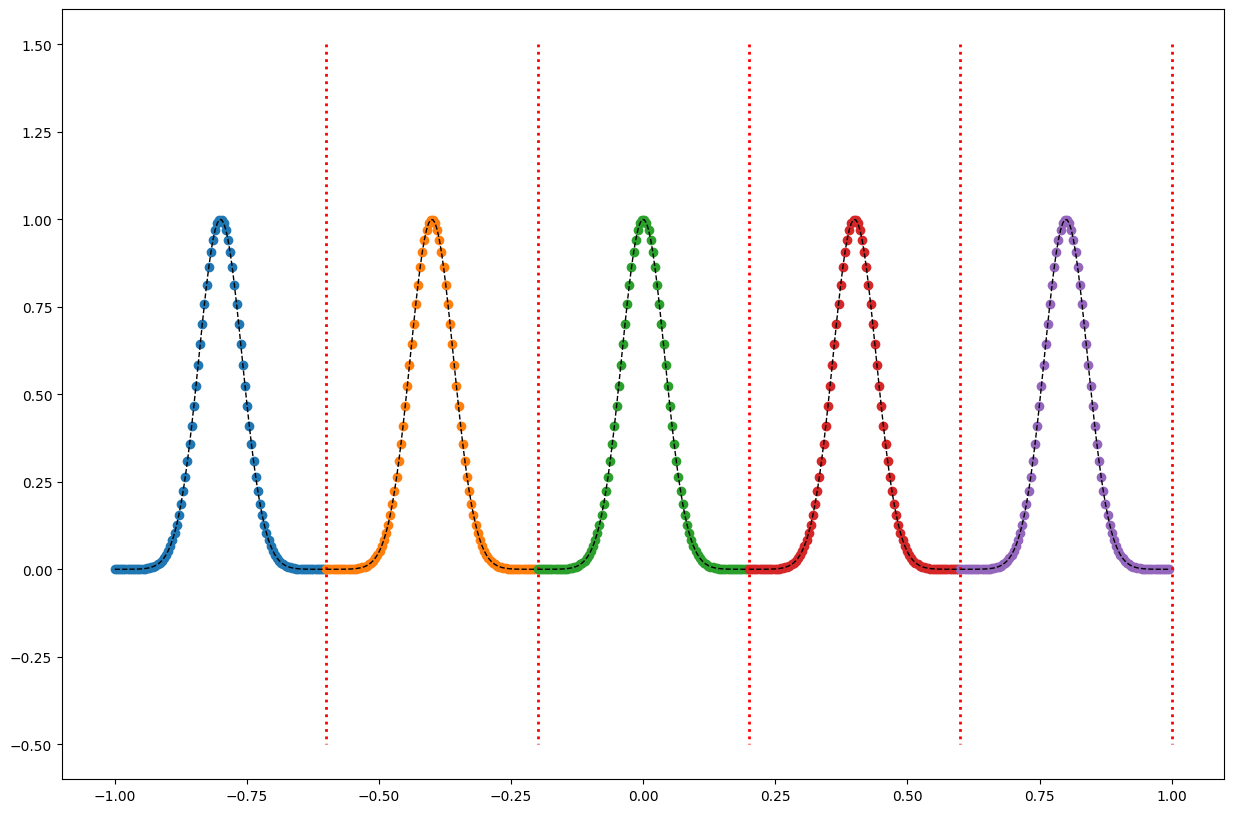

In [18]:
datasets = []

n_peak = n_phases = 5
noise_level = 0
n_num_per_peak = 100
n_sample = n_peak * n_num_per_peak

x_grid = torch.linspace(-1,1,steps=n_sample)

x_centers = 2/n_peak * (np.arange(n_peak) - n_peak/2+0.5)

x_sample = torch.stack([torch.linspace(-1/n_peak,1/n_peak,steps=n_num_per_peak)+center for center in x_centers]).reshape(-1,)


y = 0.
for center in x_centers:
    y += torch.exp(-(x_grid-center)**2*300)
    
y_sample = 0.
for center in x_centers:
    y_sample += torch.exp(-(x_sample-center)**2*300)
    

#plt.plot(x_grid.detach().numpy(), y.detach().numpy())
#plt.scatter(x_sample.detach().numpy(), y_sample.detach().numpy())
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 10), dpi=100)
data_list,GT_list=[],[]
seg_num = int(x_grid.shape[0]/n_phases)
for i in range(n_phases):
    start = i * seg_num 
    end = start + seg_num -1
    x_p = x_sample[start:end].view(-1,1)
    y_p = y_sample[start:end].view(-1,1)
    y_noisy=y_p + noise_level * torch.randn(y_p.shape)
    data_list.append((x_p,y_noisy))
    GT_list.append((x_p,y_p))
    ax.scatter(x_p.detach().numpy(), y_noisy.detach().numpy())
    ax.vlines(x_sample[end], 1.5, -0.5, color='red', linestyle=':', linewidth=2)
    ax.plot(x_p.detach().numpy(), y_p.detach().numpy(), color='black', linewidth=1, linestyle='--')

Stopping: No further improvements...
Stopping: Iteration limit reached...
Phase: 0	 KAN Loss:  0.1405
Phase: 0	 MLP Loss:  0.0583
MLP Avg. loss:  0.05835
KAN Avg. loss:  0.14183


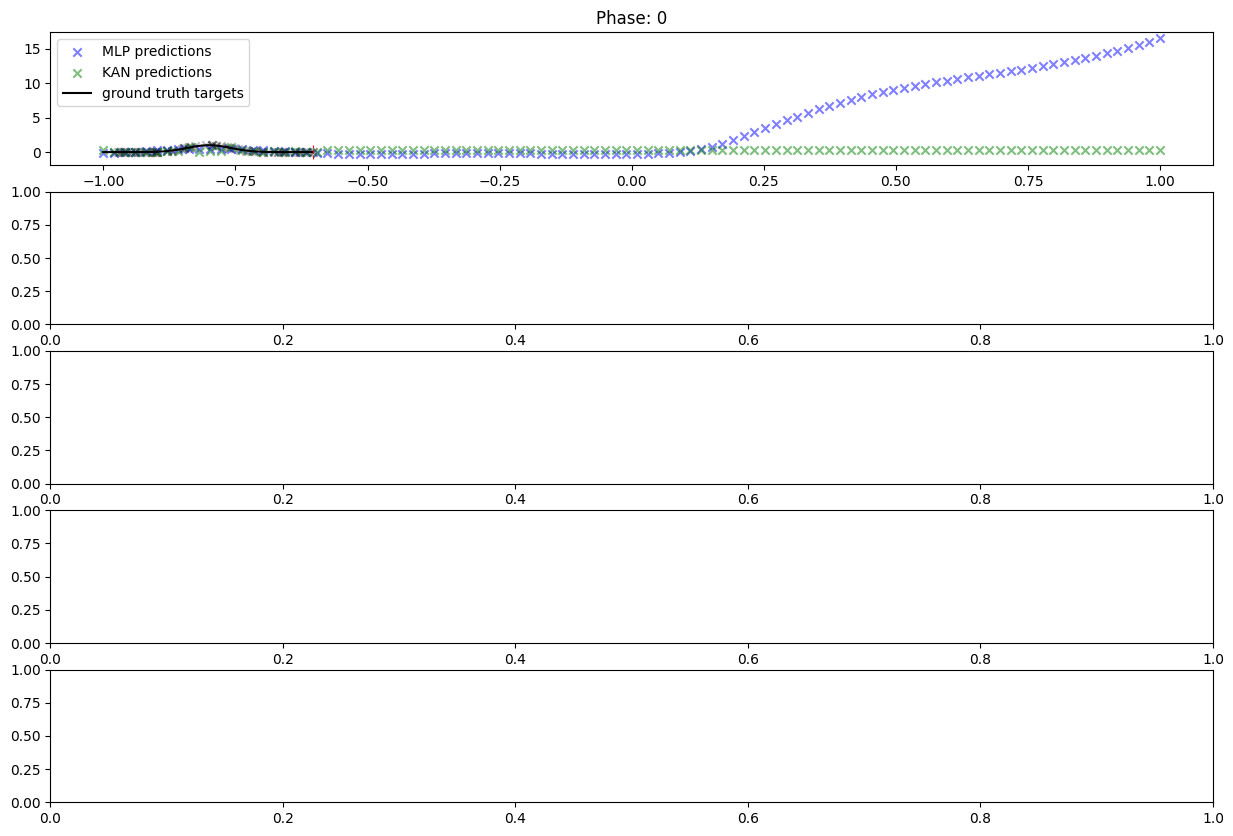

In [30]:
fig, axs = plt.subplots(nrows=n_phases, ncols=1, figsize=(15, 10), dpi=100)

# Setting for KAN
losses = []
grid_sizes = [200,200]
grid_range = [-1, 1]
lr = 0.1
k = 3
n_layers = 2

# Setting for MLP
layer_sizes = [32,32,32] 
# train standard neural network to fit training data
#torch.manual_seed(123)
#model = MLP(1,1,200,2)
#optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)

params_kan, params_mlp = None,None
x_temps, y_temps, ends, y_noisys = [], [], [], []
for i in range(1):
    # reterive local data
    x_eval,y_target=data_list[i]

    # test and train split
    n_training = int(x_eval.shape[0] * 0.8)
    training_idxs = np.random.randint(x_eval.shape[0], size=n_training)
    test_idxs = [i for i in range(x_eval.shape[0]) if i not in training_idxs]
    x_training = x_eval[training_idxs]
    x_test = x_eval[test_idxs]
    y_training = y_target[training_idxs]
    y_test = y_target[test_idxs]

    # train using the same model (model_params=params_kan)
    params_kan, y_pred_kan, losses_kan, all_xs = single_stacked_kan_training(x_training, y_training, x_test, y_test, lr=lr, model_params=params_kan, 
                                                                             k=k, n_layers=n_layers, 
                                                                             grid_sizes=grid_sizes, verbose=False, 
                                                                             grid_range=[], use_scales=False)
    

    # MLP training 
    params_mlp, y_pred_mlp, losses_mlp = single_stacked_mlp_training(x_training, y_training, x_test, y_test,params_mlp,lr=1e-4, layer_sizes=layer_sizes, early_stopping_imrpovement_threshold=1000,verbose=False)
   
   
    losses.append(losses_kan)
    print(f"Phase: {i}\t KAN Loss: {np.mean(losses_kan['val'][-50:]): 0.4f}")
    print(f"Phase: {i}\t MLP Loss: {np.mean(losses_mlp['val'][-50:]): 0.4f}")

    # predictions vs target
    ax = axs[i]
    ax.scatter(x_training, y_training, color='black', marker='x', alpha=0.25) # training data
    for temp_x, temp_y in y_noisys:
        ax.scatter(temp_x, temp_y, color='black',marker='x', alpha=0.25, ) # old training data

    y_noisys.append((x_eval,y_target))


    x_in = torch.linspace(-1, 1, 100).unsqueeze(dim=1)
    y_pred = model_predict(params_kan, x_in, k)

    # MLP prediction on all domain
    with torch.no_grad():
        weights, biases = params_mlp['weights'], params_mlp['biases']
        x = x_in
        for weight, bias in zip(weights, biases):
            x = F.linear(x, weight.t(), bias)
            x = F.silu(x) # relu might not work better here
        y_pred_mlp = x

    ax.scatter(x_in[:, 0], y_pred_mlp, color='blue', alpha=0.5, marker='x', label="MLP predictions")
    ax.scatter(x_in[:, 0], y_pred, color='green', alpha=0.5, marker='x', label="KAN predictions")

    x_temp, y_temp = GT_list[i]
    ax.plot(x_temp, y_temp, linestyle='-',  color='black', label="ground truth targets")
    for x,y in zip(x_temps, y_temps):
        ax.plot(x, y, linestyle='-', alpha=0.5, color='black')

    ends.append(x_eval[-1,0])
    for x in ends:
        ax.vlines(x, -1, 1, linestyle='--', color='red', linewidth=0.75)

    ax.set_title(f"Phase: {i}")
    if i == 0:
        ax.legend()

    x_temps.append(x_temp)
    y_temps.append(y_temp)

    

#print(f"Number of parameters learned for MLP: {sum([x.numel() for x in weights]) + sum([x.numel() for x in biases])}")
print(f"MLP Avg. loss: {np.mean(losses_mlp['val'][-100:]): 0.5f}")

print(f"KAN Avg. loss: {np.mean(losses_kan['val'][-100:]): 0.5f}")

**Observations:**

The green points indicate the predictions of the learned KAN. As observed in successive phases of the dataset, the function learned from previous input domains is retained. This consistency allows for continual learning without catastrophic forgetting.

### Summary

In this session, we explored how the grid in B-splines can be utilized effectively to enhance model capacity without the need to retrain models. We also examined how these grids help prevent catastrophic forgetting in continual learning scenarios.

### What's next?

In the next notebook, we will explore how to perform symbolic learning using KANs.